# L2 prediction

Apziva project #5: ValueInvestor<br>
2023 09 04

__Summary:__
* L2 is used here to predict prices.
* The training periods have a duration of 30 days (1 month).
* The predictions are __worse than those from the dummy__.
* Feature importance:
    * The predictions are mostly determined by the __previous day__.
    * PCA is of no help here.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [Installation](#Installation)
* [Create training and test dataset](#CreateTrainingAndTestDataset)
* [Run L2](#RunL2)
    * [L2 without PCA](#L2WithoutPCA)
    * [L2 with PCA](#L2WithPCA)
* [Use L2 to predict](#UseL2ToPredict)

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

def CheckNewYear(dfrSource):
    '''
    Checks a dateframe for the days between 2022 and 2023
    When       Who What
    2023 09 08 dh  Created
    '''
    p("Check new year 2022/2023:")
    strStartDate = '2022-12-28'
    strEndDate   = '2023-01-09'
    dfrFiltered = dfrSource[(dfrSource['Date'] >= strStartDate) \
                                  & (dfrSource['Date'] <= strEndDate)]
    u.DisplayDataFrame(dfrFiltered)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

def RMSE(srs1,srs2):
    squared_error = (srs1 - srs2) ** 2
    mean_squared_error = np.mean(squared_error)
    fltRMSE = np.sqrt(mean_squared_error)
    return fltRMSE

def PlotTimeSeries(dfr, lstrColumns, blnShowZoom=False):
    '''
    Plots time series, separating training and test phase using a red line.
    When       Who What
    2023 09 21 dh  Created
    '''
    # init
    p("Microsoft stock market prices 2020 to 2023".upper())
    p("- The red line separates training data from test data.")
    p()
    astrColors = ["orange","black","gray","green","blue","red","purple"] * 10
    tstStartTest = pd.to_datetime('2023-01-01')
    dstrCaptions = {
        "All":"Training and test period",
        "Test":"Test period only",
        "Zoom":"Zoom New Year 2023"
    }
    
    # plot 2 or 3 plots
    lstrPlotTypes = ["All","Test","Zoom"] if blnShowZoom else ["All","Test"]
    
    for strPlotType in lstrPlotTypes:
        
        # init
        p(f"• {dstrCaptions[strPlotType]}:")            
        plt.figure(figsize=(21, 5))
        
        # scatter plot    
        for intIndex,strColumn in enumerate(lstrColumns):
            
            # metric
            if strColumn=="Price":
                srsTrueValues = dfr[strColumn]
                strMetricToLabel = ""
            else:
                srsPredictedValues = dfr[strColumn]
                fltRMSE = RMSE(srsTrueValues,srsPredictedValues)
                strMetricToLabel = f" RMSE={round(fltRMSE,1)}"
            
            plt.plot(dfr['Date'], dfr[strColumn], color=astrColors[intIndex], marker='', linestyle='-', label=f"{strColumn}{strMetricToLabel}")

        # time range (timestamps)
        if strPlotType == "All":
            tstFirstDate = dfr['Date'].min()
            tstLastDate = dfr['Date'].max()
        if strPlotType == "Test":
            tstFirstDate = tstStartTest - timedelta(days=1)
            tstLastDate = dfr['Date'].max()
        if strPlotType == "Zoom":
            tstFirstDate = tstStartTest - timedelta(days=1)
            tstLastDate = pd.to_datetime('2023-01-31')
            filtered_df = dfr[(dfr['Date'] >= tstFirstDate) & (dfr['Date'] <= tstLastDate)]
            fltLowestPrice = filtered_df['Price'].min()
            fltHighestPrice = filtered_df['Price'].max()
            plt.ylim(fltLowestPrice, fltHighestPrice)
        
        # customize plot
        plt.xlim(tstFirstDate, tstLastDate)
        plt.grid(True)
        plt.xlabel('Date')
        plt.ylabel("Prices, true or predicted")
        plt.legend()

        # separator for training/test data
        #if strPlotType or True:
        plt.axvline(x=tstStartTest, color='red', linestyle='--')

        # finalize
        plt.show()

## Installation <a class="anchor" id="Installation"></a>
[TOC](#TOC)

In [40]:
# installation
# pip install nothing so far

## Create training and test dataset <a class="anchor" id="CreateTrainingAndTestDataset"></a>
[TOC](#TOC)

In [41]:
# get the data

import pickle
import pandas as pd
strFilename = f"../data/processed/dfrPredictionDummy.p"
with open(strFilename, 'rb') as objBufferedWriter: # rb = read in binary mode
    dfrPredictionL2 = pickle.load(objBufferedWriter)
u.ShortDataFrameDisplay(dfrPredictionL2)

DataFrame 'dfrPredictionL2':


,Date,Price,Differences,PredDummy
12347,2020-01-01,153.010615,0.000000,153.010615
12348,2020-01-02,154.205344,1.194729,154.205344
...,...,...,...,...
13690,2023-09-05,331.274994,0.322970,257.191823
13691,2023-09-06,333.130005,1.855011,257.269338


__Decision__
* I use 30 days of price data to predict the next price. One month is...
    * ... long enough to include weekly oscillations (if present).
    * ... short enough to get enough training data.
* I am currently not sure if the fact that records contain identical, but shifted X values will be a problem to create reasonable L2 results.

In [42]:
import numpy as np

# get data as Numpy arrays
a1fltDifferences = dfrPredictionL2["Differences"].values
a1strDate = dfrPredictionL2["Date"].values

# definitions
cintDaysToLearnFrom = 30 #  productive: 365
n = len(a1fltDifferences)
m = cintDaysToLearnFrom      # number of columns for X_0000 to X_1094
y_col = cintDaysToLearnFrom  # Column index for 'y' in dfrXy

# Initialize arrays for 'Date', 'X', and 'y'
dates = a1strDate[m:]
X = np.zeros((n - m, m))
y = np.zeros(n - m)

# Fill 'Date' and 'X' arrays
for i in range(m, n):
    dates[i - m] = a1strDate[i]
    X[i - m, :] = a1fltDifferences[i - m:i]

# Fill 'y' array
y = a1fltDifferences[m:]

# Now you can convert 'dates', 'X', and 'y' into a DataFrame if needed
dfrXy = pd.DataFrame({"Date": dates, **{f"X_{i:04d}": X[:, i] for i in range(m)}, "y": y})

p("Verifying data set:")
p(f"- X: {X.shape}")
p(f"- y: {y.shape}")
p()
u.ShortDataFrameDisplay(dfrXy,7)
p("Verification: from record to record, X values (and y values, too) are shifted to the left.")
p()

# shorten to data before 2023
intLengthTraining = len(dfrXy[dfrXy['Date'] < '2023-01-01'])
X = X[:intLengthTraining]
y = y[:intLengthTraining]

p("Training data, i.e. only before 2023:")
p(f"- X: {X.shape}")
p(f"- y: {y.shape}")
p()

Verifying data set:
- X: (1315, 30)
- y: (1315,)

DataFrame 'dfrXy':


,Date,X_0000,X_0001,X_0002,X_0003,X_0004,X_0005,X_0006,X_0007,X_0008,...,X_0021,X_0022,X_0023,X_0024,X_0025,X_0026,X_0027,X_0028,X_0029,y
0,2020-01-31,0.000000,1.194729,-1.187671,-0.133693,-0.133577,-0.133460,0.381406,1.023529,2.370515,...,-0.038653,-0.091726,-0.173802,-1.481329,-1.467662,-1.454120,2.805032,3.205756,5.286647,-2.119461
1,2020-02-01,1.194729,-1.187671,-0.133693,-0.133577,-0.133460,0.381406,1.023529,2.370515,0.111047,...,-0.091726,-0.173802,-1.481329,-1.467662,-1.454120,2.805032,3.205756,5.286647,-2.119461,0.380525
2,2020-02-02,-1.187671,-0.133693,-0.133577,-0.133460,0.381406,1.023529,2.370515,0.111047,0.141503,...,-0.173802,-1.481329,-1.467662,-1.454120,2.805032,3.205756,5.286647,-2.119461,0.380525,0.381401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2023-09-04,-0.196379,-0.196262,-0.196145,-2.729225,-2.150414,0.124704,-3.831866,0.690386,0.691876,...,0.816264,0.818332,0.820405,0.464996,3.585007,-0.250000,1.504990,0.322027,0.322341,0.322655
1313,2023-09-05,-0.196262,-0.196145,-2.729225,-2.150414,0.124704,-3.831866,0.690386,0.691876,0.693369,...,0.818332,0.820405,0.464996,3.585007,-0.250000,1.504990,0.322027,0.322341,0.322655,0.322970
1314,2023-09-06,-0.196145,-2.729225,-2.150414,0.124704,-3.831866,0.690386,0.691876,0.693369,-0.284445,...,0.820405,0.464996,3.585007,-0.250000,1.504990,0.322027,0.322341,0.322655,0.322970,1.855011


Verification: from record to record, X values (and y values, too) are shifted to the left.

Training data, i.e. only before 2023:
- X: (1066, 30)
- y: (1066,)



## Run L2 <a class="anchor" id="RunL2"></a>
[TOC](#TOC)

### L2 without PCA <a class="anchor" id="L2WithoutPCA"></a>
[TOC](#TOC)

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

cfltRandomSeed = 42

def RunL2(X,y,blnWithPCA):
    '''
    Runs an L2 regression. Alternatives: with/without feature importance analysis.
    
    When       Who What
    2023 09 10 dh  Created
    '''
    
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=cfltRandomSeed)

    if blnWithPCA:

        objPipeline = Pipeline([
            ('pca', PCA(random_state=cfltRandomSeed)),  # Adjust PCA hyperparameters as needed
            ('ridge', Ridge(random_state=cfltRandomSeed))  # Adjust Ridge hyperparameters as needed
        ])
        objParameterGrid = {
            'pca__n_components': [2,5,10,20],   # debugging
            'ridge__alpha': [0.1,0.5,1,2,5]  
        }    
    else: # without PCA
        objPipeline = Pipeline([
            ('ridge', Ridge(random_state=cfltRandomSeed)) 
        ])
        objParameterGrid = {
            'ridge__alpha': [200,500,1000,2000,5000,10000,20000]  
        }          
    
    # cross-validation and grid search
    objCrossValidation = KFold(n_splits=5, random_state=cfltRandomSeed, shuffle=True)
    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, cv=objCrossValidation, scoring='neg_mean_squared_error')
    objGridSearch.fit(X_train, y_train)
    objBestModel = objGridSearch.best_estimator_
    
    # RMSE for the test dataset
    y_pred = objBestModel.predict(X_test)
    fltRMSE = np.sqrt(mean_squared_error(y_test, y_pred))    
    p("RMSE:")
    p("   ",round(fltRMSE,5))
    
    # grid search result
    p("Best Hyperparameters:")
    p(objGridSearch.best_params_)
 
    # absolute values of the coefficients
    a1fltCoefficients = objBestModel.named_steps['ridge'].coef_
    a1fltAbsoluteCoefficients = np.abs(a1fltCoefficients)

    # column chart with coefficients
    plt.figure(figsize=(17, 3))
    intCoefficients = len(a1fltAbsoluteCoefficients)
    plt.bar(range(intCoefficients), a1fltAbsoluteCoefficients, color='orange')
    plt.xlabel('Feature index')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Absolute values of ridge regression coefficients')
    intExtraSpace = 2
    plt.xlim(0-intExtraSpace, intCoefficients+intExtraSpace) 
    plt.show()
    
    # finalize
    return objBestModel

RMSE:
    2.44801
Best Hyperparameters:
{'ridge__alpha': 5000}


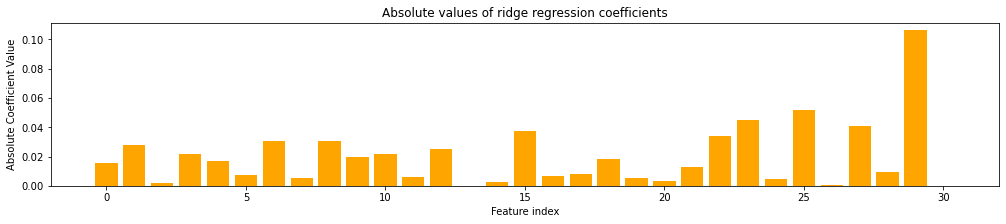

In [44]:
objBestModel = RunL2(X,y,blnWithPCA=False)
u.ToDisk(objBestModel,strForcedName="objBestL2PcaNo",strType="models")

__Observations__
* Without PCA, the model focusses on the very last value, the price of the day before the prediction day.

### L2 with PCA <a class="anchor" id="L2WithPCA"></a>
[TOC](#TOC)

RMSE:
    2.50279
Best Hyperparameters:
{'pca__n_components': 10, 'ridge__alpha': 5}


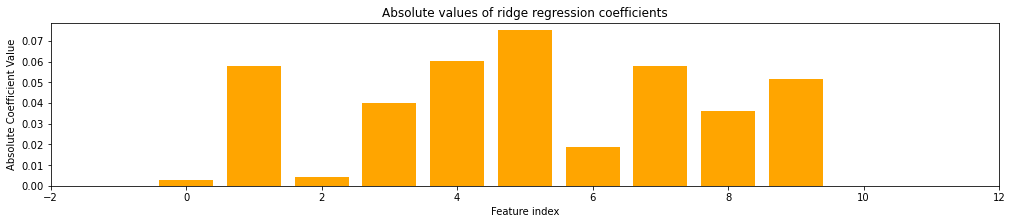

In [45]:
if True:
    objBestModel = RunL2(X,y,blnWithPCA=True)
    u.ToDisk(objBestModel,strForcedName="objBestL2PcaYes",strType="models")
else:
    p("Screenshot of run on 2023-09-21:")

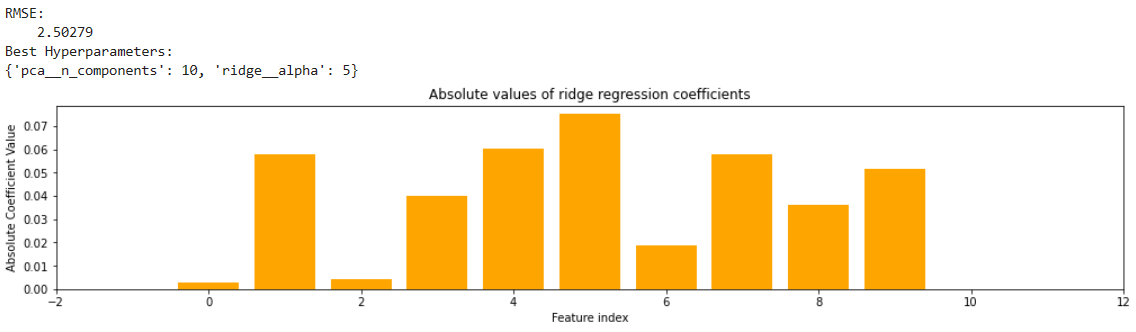

__Observations__
* PCA does not improve the model.
* Thus, the price of day x is predicted best, just using the price of day x-1.

## Use L2 to predict <a class="anchor" id="UseL2ToPredict"></a>
[TOC](#TOC)

In [46]:
import pandas as pd
def AccumulateFromDifferences(dfr,strOldColumn,strDifferenceColumn,strNewColumn):

    # init
    dfr[strNewColumn] = float('nan')
    dfr.reset_index(drop=True, inplace=True)

    # accumulate
    for intRecord in range(len(dfr)):
        if intRecord == 0:
            dfr.at[intRecord, strNewColumn] = dfr.at[intRecord, strOldColumn]
        else:
            fltPreviousOldValue = dfr.at[intRecord - 1, strNewColumn]
            fltDifference = dfr.at[intRecord, strDifferenceColumn]
            dfr.at[intRecord, strNewColumn] = fltPreviousOldValue + fltDifference
            
    # finalize
    return dfr

Check new year 2022/2023:


,Date,Price,Differences,PredDummy,DifferenceL2,PredL2
1092,2022-12-28,234.112570,-2.105624,234.112570,-2.105624,234.112570
1093,2022-12-29,236.714810,2.602240,236.714810,2.602240,236.714810
1094,2022-12-30,237.395157,0.680347,237.395157,0.680347,237.395157
1095,2022-12-31,237.967909,0.572752,237.967909,0.572752,237.967909
1096,2023-01-01,238.542043,0.574134,238.045425,0.372676,238.340585
1097,2023-01-02,239.117562,0.575519,238.122941,0.181471,238.522056
1098,2023-01-03,239.694469,0.576907,238.200457,0.271020,238.793076
1099,2023-01-04,229.126584,-10.567885,238.277972,-0.342316,238.450760
1100,2023-01-05,223.231789,-5.894795,238.355488,-0.349712,238.101048
1101,2023-01-06,222.447153,-0.784637,238.433004,0.371312,238.472360


MICROSOFT STOCK MARKET PRICES 2020 TO 2023
- The red line separates training data from test data.

• Training and test period:


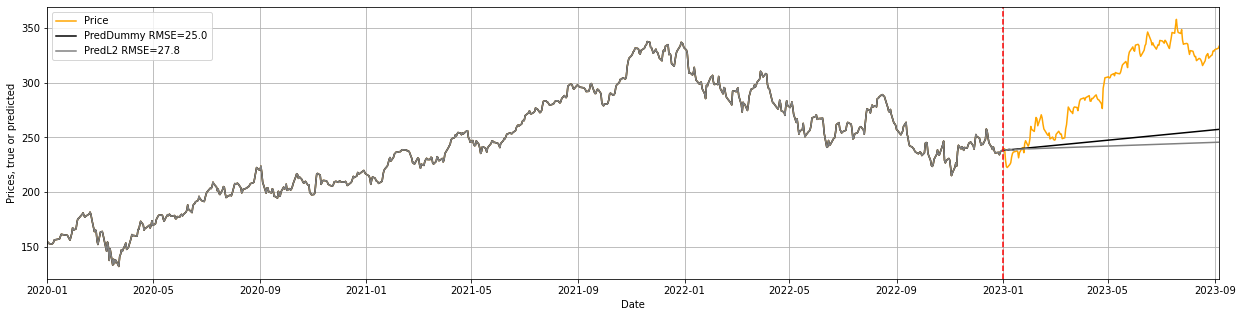

• Test period only:


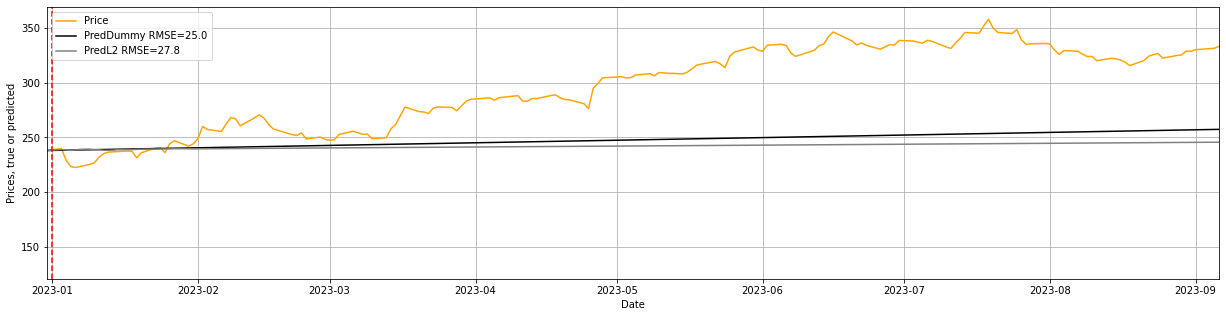

• Zoom New Year 2023:


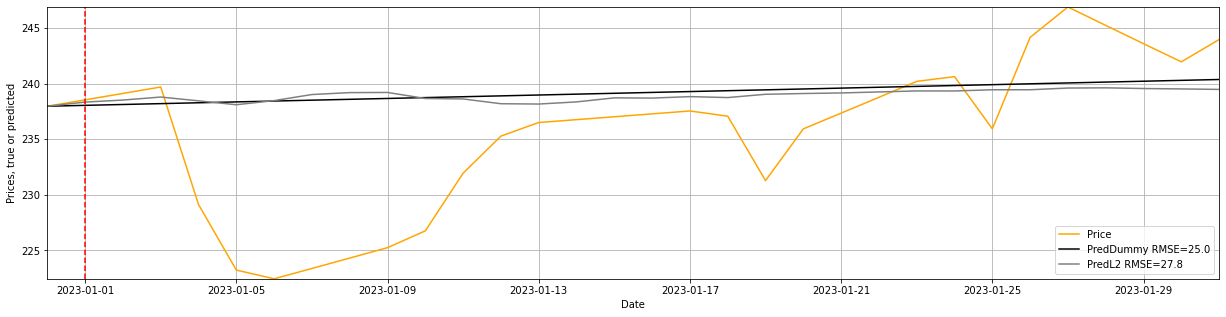

In [55]:
import numpy as np

# get model to go with
strFilename = f"../models/objBestL2PcaNo.p"
with open(strFilename, 'rb') as objBufferedWriter: # rb = read in binary mode
    objL2Model = pickle.load(objBufferedWriter)

# get numpy arrays
a1strDates = dfrPredictionL2["Date"].values
a1PredL2 = dfrPredictionL2["Differences"].copy().values

# iterate through the records
for intRow, strDate in enumerate(a1strDates):

    if (strDate >= np.datetime64('2023-01-01')):
        intPreviousRow = intRow-1
        X_singletest = a1PredL2[intPreviousRow - cintDaysToLearnFrom:intPreviousRow].reshape(1, -1)

        # predict price using the L2 model
        y_pred = objL2Model.predict(X_singletest)
        fltPrediction = y_pred[0]
        a1PredL2[intRow] = fltPrediction
    
dfrPredictionL2["DifferenceL2"] = a1PredL2
dfrPredictionL2 = AccumulateFromDifferences(dfrPredictionL2,strOldColumn="Price",strDifferenceColumn="DifferenceL2",strNewColumn="PredL2")

u.ToDisk(dfrPredictionL2,strForcedName="dfrPredictionL2",strType="processed")
CheckNewYear(dfrPredictionL2)

PlotTimeSeries(dfrPredictionL2,["Price","PredDummy","PredL2"],blnShowZoom=True)

__Observations__
* The prediction results in a monotonically increasing function.
* The __L2 predictions deviate slightly__ from the linear dummy, but later become linear as well.
* The __L2 prediction__ is __worse than the dummy__.